# Tutorial with LSST

We will use the parameter file "tests/parametersTest.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
**fit each object with our GP using ugi bands only and see how it predicts the rz bands.**
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
#%cd /Users/sylvie/MacOSX/GitHub/LSST/Delight
%cd ..

/Users/sylvie/MacOSX/GitHub/LSST/Delight


In [3]:
%mkdir tests_lsst

mkdir: tests_lsst: File exists


In [4]:
%mkdir data_lsst

mkdir: data_lsst: File exists


## Creating the parameter file
Let's create a parameter file from scratch.

In [5]:
paramfile_txt = """
# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column
"""

Let's describe the bands we will use. This must be a superset (ideally the union) of all the bands involved in the training and target sets, including cross-validation. 

Each band should have its own file, containing a tabulated version of the filter response.

See example files shipped with the code for formatting.

In [6]:
paramfile_txt += """
[Bands]
names: lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
directory: data/FILTERS
numCoefs: 15
bands_verbose: True
bands_debug: True
bands_makeplots: True
"""

Let's now describe the system of SED templates to use (needed for the mean fct of the GP, for simulating objects, and for the template fitting routines).

Each template should have its own file (see shipped files for formatting example). 

- **lambdaRef** will be the pivot wavelenght used for normalizing the templates.

- **$p(z|t)$ and $p(t)$** containts parameters for the priors of each template, for $p(z|t) p(t)$. 

- Calibrating those numbers will be the topic of another tutorial.

By default the set of templates and the prior calibration can be left untouched.

In [7]:
paramfile_txt += """
[Templates]
directory: ./data/CWW_SEDs
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t:0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3
"""

The next section if for simulating a photometric catalogue from the templates. 

- **catalog files** (trainingFile, targetFile) will be created, and have the adequate format for the later stages. 

- **noiseLevel** describes the relative error for the absolute flux in each band.

In [8]:
paramfile_txt += """
[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: data_lsst/galaxies-fluxredshifts.txt
targetFile: data_lsst/galaxies-fluxredshifts2.txt
"""

We now describe the training file.

- `catFile` is the input catalog. This should be a tab or space separated file with numBands + 1 columns.

- `bandOrder` describes the ordering of the bands in the file. Underscore `_` means an ignored column, for example a band that shouldn't be used. The band names must correspond to those in the filter section.

- `redshift` is for the photometric redshift. 
- `referenceBand` is the reference band for normalizing the fluxes and luminosities. 
- `extraFracFluxError` is an extra relative error to add in quadrature to the flux errors.

- `paramFile` will contain the output of the GP applied to the training galaxies, i.e. the minimal parameters that must be stored in order to reconstruct the fit of each GP.

- `crossValidate` is a flag for performing optional cross-validation. If so, `CVfile` will contain cross-validation data. `crossValidationBandOrder` is similar to `bandOrder` and describes the bands to be used for cross-validation. In this example I have left the R band out of `bandOrder` and put it in `crossValidationBandOrder`. However, this feature won't work on simulated data, only on real data (i.e., the `simulateWithSEDs` script below does not generate cross-validation bands).

- `numChunks` is the number of chunks to split the training data into. At present please stick to 1.

In [9]:
paramfile_txt += """
[Training]
catFile: data_lsst/galaxies-fluxredshifts.txt
bandOrder: lsst_u lsst_u_var lsst_g lsst_g_var _ _ lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift
referenceBand: lsst_i
extraFracFluxError: 1e-4
paramFile: data_lsst/galaxies-gpparams.txt
crossValidate: False
CVfile: data_lsst/galaxies-gpCV.txt
crossValidationBandOrder: _ _ _ _ lsst_r lsst_r_var _ _ _ _ _ _
numChunks: 1
"""

The section of the target catalog has very similar structure and parameters. The `catFile`, `bandOrder`, `referenceBand`, and `extraFracFluxError` have the same meaning as for the training, but of course don't have to be the same.

- `redshiftpdfFile` and `redshiftpdfFileTemp` will contain tabulated redshift posterior PDFs for the delight-apply and templateFitting scripts. 

- Similarly, `metricsFile` and `metricsFileTemp` will contain metrics calculated from the PDFs, like mean, mode, etc. This is particularly informative if `redshift` is also provided in the target set.

- The compression mode can be activated with `useCompression` and will produce new redshift PDFs in the file `redshiftpdfFileComp`, while `compressIndicesFile` and `compressMargLikFile` will contain the indices and marginalized likelihood for the objects that were kept during compression. The number of objects is controled with `Ncompress`.

In [10]:
paramfile_txt += """
[Target]
catFile: data_lsst/galaxies-fluxredshifts2.txt
bandOrder: lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var _ _ lsst_z lsst_z_var lsst_y lsst_y_var redshift
referenceBand: lsst_r
extraFracFluxError: 1e-4
redshiftpdfFile: data_lsst/galaxies-redshiftpdfs.txt
redshiftpdfFileTemp: data_lsst/galaxies-redshiftpdfs-cww.txt
metricsFile:  data_lsst/galaxies-redshiftmetrics.txt
metricsFileTemp:  data_lsst/galaxies-redshiftmetrics-cww.txt
useCompression: False
Ncompress: 10
compressIndicesFile: data_lsst/galaxies-compressionIndices.txt
compressMargLikFile: data_lsst/galaxies-compressionMargLikes.txt
redshiftpdfFileComp: data_lsst/galaxies-redshiftpdfs-comp.txt
"""

Finally, there are various other parameters related to the method itself.

- The (hyper)parameters of the Gaussian process are `zPriorSigma`, `ellPriorSigma` (locality of the model predictions in redshift and luminosity), `fluxLuminosityNorm` (some normalization parameter), `alpha_C`, `alpha_L`, `V_C`, `V_L` (smoothness and variance of the latent SED model), `lines_pos`, `lines_width` (positions and widths of the lines in the latent SED model). 

- `redshiftMin`, `redshiftMax`, and `redshiftBinSize` describe the linear fine redshift grid to compute PDFs on.

- `redshiftNumBinsGPpred` describes the granuality (in log scale!) for the GP kernel to be exactly calculated on; it will then be interpolated on the finer grid.

- `redshiftDisBinSize` is the binsize for a tomographic redshift binning.

- `confidenceLevels` are the confidence levels to compute in the redshift PDF metrics.

The values below should be a good default set for all of those parameters. 

In [11]:
paramfile_txt += """
[Other]
rootDir: ./
zPriorSigma: 0.2
ellPriorSigma: 0.5
fluxLuminosityNorm: 1.0
alpha_C: 1.0e3
V_C: 0.1
alpha_L: 1.0e2
V_L: 0.1
lines_pos: 6500 5002.26 3732.22
lines_width: 20.0 20.0 20.0
redshiftMin: 0.1
redshiftMax: 1.101
redshiftNumBinsGPpred: 100
redshiftBinSize: 0.001
redshiftDisBinSize: 0.2
confidenceLevels: 0.1 0.50 0.68 0.95
"""

In [12]:
with open('tests_lsst/parametersTest.cfg','w') as out:
    out.write(paramfile_txt)

## Running Delight

### Processing the filters and templates, and create a mock catalog

- First, we must fit the band filters with a gaussian mixture. 
This is done with this script:

In [13]:
%run ./scripts/processFilters.py tests_lsst/parametersTest.cfg

2021-02-13 18:13:58,714 processFilters.py __main__[89357] INFO Start processFilters.py
2021-02-13 18:13:58,717 processFilters.py __main__[89357] INFO --- Process FILTERS ---
2021-02-13 18:13:58,719 ipykernel_launcher.py, delight.io[89357] WARNING Input parameter file:tests_lsst/parametersTest.cfg
2021-02-13 18:13:58,720 ipykernel_launcher.py, delight.io[89357] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      data/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      True
>  templates_directory  ./data/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   data_lsst/galaxies-gpparams.txt
>  training_catFile     data_lsst/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g lsst_g_var _ _ lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift
>  training_extraFracFluxError 0.0001
>  training_crossVa

/Users/sylvie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 6200.
  warnings.warn(errors[info][0], RuntimeWarning)


lsst_y 

- Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [14]:
%run ./scripts/processSEDs.py tests_lsst/parametersTest.cfg

2021-02-13 18:14:15,409 processSEDs.py, __main__[89357] INFO --- Process SED ---


- Third, we will make some mock data with those filters and SEDs:

produce files `galaxies-redshiftpdfs.txt` and `galaxies-redshiftpdfs2.txt` for trainning and target

In [15]:
%run ./scripts/simulateWithSEDs.py tests_lsst/parametersTest.cfg

2021-02-13 18:14:39,532 simulateWithSEDs.py, __main__[89357] INFO --- Simulate with SED ---


### Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to **1e4 objects** it should only take a few minutes max, depending on the settings above.

In [16]:
%run ./scripts/templateFitting.py tests_lsst/parametersTest.cfg

2021-02-13 18:14:40,093 templateFitting.py, __main__[89357] INFO --- TEMPLATE FITTING ---


--- TEMPLATE FITTING ---
Thread number / number of threads:  1 1
Input parameter file: tests_lsst/parametersTest.cfg
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/templateFitting.py:67: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


In [17]:
%run ./scripts/delight-learn.py tests_lsst/parametersTest.cfg

2021-02-13 18:14:49,077 delight-learn.py, __main__[89357] INFO --- DELIGHT-LEARN ---
/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-learn.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


Number of Training Objects 1000
Thread  0  analyzes lines  0  to  1000


In [18]:
%run ./scripts/delight-apply.py tests_lsst/parametersTest.cfg

2021-02-13 18:15:03,410 delight-apply.py, __main__[89357] INFO --- DELIGHT-APPLY ---
/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-apply.py:51: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-apply.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


Number of Training Objects 1000
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000
None band 2 y_pred_bin [2509.91440042 2406.07819156 2304.26531335 2208.26908324 2118.03024725
 2033.18304436 1953.5872627  1876.44887434 1798.4032024  1720.25168237
 1645.45489349 1572.84125117 1500.16124526 1428.91439058 1361.57392338
 1298.35792931 1238.12540978 1180.35148433 1125.02938894 1072.22006044
 1021.96064933  973.26106255  926.19133549  881.73220063  840.14099879
  800.59919183  762.42008411  726.36256739  692.2216732   659.98098724
  629.30056906  599.80152876  571.97056796  545.9147048   520.84586539
  496.75136561  474.39754525  453.11098665  432.18264563  412.89205761
  395.41405893  377.82028805  361.19274979  345.75344418  330.26416844
  315.88818314  302.08682851  288.72508429  276.12780934  263.79819804
  252.00320516  240.31142035  226.64219742  212.27244467  194.67541493
  180.59415828  164.94386075  150.22040874  139.29070583  131.29371686
  124.19171196  117.5873

  1.08771558e-06  9.90566663e-07  9.02242490e-07  8.21929946e-07]
None band 2 y_pred_bin [2602.79401988 2477.67460509 2358.18813941 2244.91784661 2137.16130594
 2034.71986918 1937.1953175  1843.95470775 1754.81748611 1669.76133177
 1588.66918624 1511.23361963 1437.1092966  1366.20917952 1298.52643726
 1234.12044523 1173.13661123 1115.2542359  1060.19732898 1007.73057315
  957.6789259   910.02413088  864.76818047  821.88139568  781.2728172
  742.68411126  706.02585287  671.28189815  638.40223622  607.18339779
  577.46375085  549.22335109  522.4663917   497.06940641  472.85779107
  449.81033182  427.93269611  407.07015658  387.17219526  368.368869
  350.51267391  333.45256795  317.21015046  301.78007789  287.04775728
  273.04577278  259.77932879  247.15247613  235.1753596   223.77562644
  212.90504051  202.34309589  191.79111188  181.2291986   170.56265097
  160.33879603  150.35716424  140.94520719  132.49865375  124.96253076
  118.14062843  111.67551184  105.74061159  100.30053652   95.

  1.09645846e-06  9.98989864e-07  9.10339115e-07  8.29694593e-07]
None band 2 y_pred_bin [1934.22773115 1841.49160864 1753.04250453 1669.09697478 1589.17278014
 1513.16471729 1440.99951551 1372.26176588 1306.80589859 1244.38621469
 1184.88798298 1128.24985197 1074.52586705 1023.6126779   975.26125581
  929.20671822  885.37958202  843.65652814  804.11205918  766.67554709
  731.09780917  697.34605002  665.16423249  634.53358586  605.40704042
  577.71878394  551.42528684  526.32600283  502.41423753  479.6874923
  458.13268205  437.6496251   418.11595064  399.51783974  381.8182617
  364.9724419   348.89324296  333.57929056  319.02065636  305.12565144
  291.79150435  279.16983985  267.28341928  255.94734569  245.16649294
  234.96568107  225.30499231  216.118824    207.36887585  199.01938193
  190.87683631  183.11486348  175.82593797  168.71796051  161.95297879
  155.41127926  149.10953789  143.18966039  137.28684557  131.66488189
  126.23238889  120.85463017  115.59182134  110.34355708  105

None band 2 y_pred_bin [2949.71127957 2799.318447   2656.09007515 2520.44963178 2391.43764416
 2268.96196198 2152.86810329 2042.60468455 1937.88478637 1838.41204195
 1743.88938104 1654.04303466 1568.64061002 1487.58931283 1410.64675932
 1337.56500886 1268.31231685 1202.55420684 1140.14859443 1080.96342584
 1024.78373878  971.47380505  920.88752173  872.89005444  827.40938171
  784.26694412  743.36988308  704.5932657   667.83858872  632.97879247
  599.92258905  568.58300325  538.86598633  510.68603174  483.936317
  458.52155465  434.35579453  411.35752869  389.47622569  368.68446405
  348.95399921  330.25175517  312.54715783  295.80926857  280.02034422
  265.13465091  251.08334068  237.76603827  225.11606569  213.09771882
  201.65779672  190.73330883  180.23689608  170.09630259  160.29692542
  150.88286506  141.86043558  133.2494607   125.15621414  117.59638558
  110.48208606  103.74451899   97.38038627   91.37272682   85.68038191
   80.25113684   75.06032572   70.08874938   65.3510807 

None band 0 y_pred_bin [4.16132640e+02 3.91779822e+02 3.68780058e+02 3.47178768e+02
 3.26766963e+02 3.07526458e+02 2.89447488e+02 2.72418424e+02
 2.56369984e+02 2.41255667e+02 2.26997995e+02 2.13514150e+02
 2.00765564e+02 1.88736336e+02 1.77349634e+02 1.66554719e+02
 1.56351212e+02 1.46674978e+02 1.37519479e+02 1.28876101e+02
 1.20709306e+02 1.13004403e+02 1.05734732e+02 9.88723158e+01
 9.23997618e+01 8.62888192e+01 8.05216503e+01 7.50764373e+01
 6.99319075e+01 6.50677376e+01 6.04708715e+01 5.61249673e+01
 5.20149998e+01 4.81235434e+01 4.44420025e+01 4.09647951e+01
 3.76877980e+01 3.45960269e+01 3.16977565e+01 2.89958561e+01
 2.64904798e+01 2.41821592e+01 2.20775877e+01 2.01625486e+01
 1.84229136e+01 1.68407400e+01 1.53908091e+01 1.40516982e+01
 1.28088084e+01 1.16477022e+01 1.05620391e+01 9.55187004e+00
 8.61562125e+00 7.75361360e+00 6.96527249e+00 6.24748574e+00
 5.59611267e+00 5.00742471e+00 4.47751793e+00 4.00230443e+00
 3.57678113e+00 3.19686189e+00 2.85769349e+00 2.55535104e+00
 

 3.59790146e+00 3.20639452e+00 2.83742469e+00 2.48588644e+00] y_var_bin [ 1.57349057e-02  1.56129615e-02  1.40941110e-02  1.42623547e-02
 -1.87953356e-08  1.10207500e-02  8.63315884e-03  7.78609569e-03
  7.02213153e-03  6.33325563e-03  5.71207745e-03  5.15194386e-03
  4.99984797e-03  3.04538461e-03  6.56471435e-03  6.32002288e-03
  5.37825498e-03  5.16203251e-03  2.84968146e-03  4.09141884e-03
  2.23325245e-03  1.68761465e-03  1.89980610e-03 -1.32450119e-08
 -1.29384667e-08  2.03462636e-05  1.06943610e-03  1.25142657e-03
  9.96586404e-04  3.83444027e-05  7.30410405e-04  6.59413092e-04
  5.95360577e-04  5.37570684e-04  4.85428388e-04  4.38379204e-04
  3.95923233e-04  3.57609581e-04  3.23032540e-04  2.91825130e-04
  2.63657255e-04  2.38231110e-04  2.15278174e-04  1.94556327e-04
  1.75847258e-04  1.58954121e-04  1.43699402e-04  1.29923024e-04
  1.17480640e-04  1.06242068e-04  9.60898954e-05  8.69182358e-05
  7.86315771e-05  7.11385526e-05  6.43771190e-05  5.82615405e-05
  5.27337925e-05  

None band 2 y_pred_bin [2440.19949792 2317.55765242 2200.50157625 2089.62570436 1984.03823246
 1883.53382343 1788.38347672 1698.09012154 1612.2317116  1530.96252952
 1453.87734268 1380.60484607 1310.82478641 1244.21513688 1181.04921375
 1121.19645376 1064.58169067 1010.94368702  959.95231199  911.53956816
  865.63044946  822.05233775  780.45449847  741.01051029  703.70651313
  668.19371148  634.27348907  602.16517822  571.60683368  542.67858437
  515.17963631  489.04036181  464.29509076  440.83114683  418.53542843
  397.42914939  377.51374041  358.60363292  340.7328223   323.84128609
  307.77796319  292.91041276  278.57098245  264.75565462  251.85087244
  239.5433896   227.66674429  216.21160491  205.36396852  195.04068778
  185.14465823  175.71291511  166.67292186  157.99908484  149.63921199
  141.6201571   133.90416199  126.40974216  119.28711349  112.4144954
  105.98055284   99.75577282   93.99788153   88.46378142   83.36001075
   78.39462485   73.58817      69.06397836   64.6174133

None band 2 y_pred_bin [2596.97364943 2472.13399807 2352.91473241 2239.89773644 2132.38216262
 2030.16980694 1932.86334111 1839.83123619 1750.89334569 1666.02739513
 1585.11658899 1507.85418486 1433.89561966 1363.15405038 1295.62266116
 1231.36069464 1170.51323342 1112.76029532 1057.82650726 1005.47707813
  955.53735688  907.98912797  862.83437931  820.0434983   779.52577472
  741.02331539  704.44703241  669.78077229  636.97463571  605.82559324
  576.17242142  547.99517289  521.29804743  495.95785487  471.80038152
  448.80446096  426.97574797  406.15986118  386.30639561  367.54511725
  349.72885208  332.70689582  316.50079951  301.10523155  286.40585524
  272.43518185  259.19840415  246.59978752  234.64945409  223.27521287
  212.42893562  201.8906095   191.36222175  180.82392705  170.18123189
  159.98023953  150.02092868  140.63001867  132.20235339  124.68308263
  117.87643537  111.42577601  105.50414731  100.07623727   94.97925708
   90.01384576   85.18083807   80.37649794   75.642208

None band 0 y_pred_bin [563.5578705  530.61409017 499.48116286 470.21106997 442.55512092
 416.47192079 391.85648783 368.56201429 346.56129941 325.80431239
 306.1820393  287.61971122 270.07691968 253.50271399 237.85600522
 223.11232575 209.25676153 196.21951017 183.98093916 172.49711802
 161.71841956 151.61110516 142.13547229 133.25524314 124.94137268
 117.14913318 109.85338662 103.02401454  96.63649526  90.65948211
  85.06809115  79.83889354  74.94891945  70.37784958  66.10391748
  62.10843914  58.37164566  54.87739817  51.60955906  48.55197076
  45.691306    43.01466843  40.50951411  38.16435303  35.96726849
  33.90825452  31.97822023  30.1678464   28.46906523  26.8743169
  25.37681095  23.96961607  22.64665094  21.40231893  20.23162895
  19.12977941  18.09216918  17.11433756  16.19214159  15.32203221
  14.50030239  13.72412499  12.99061711  12.29703359  11.64094516
  11.02014532  10.43280037   9.87713124   9.35137963   8.85417063
   8.38409332   7.93994448   7.52054991   7.1247286   

None band 0 y_pred_bin [4.26673017e+02 4.01709040e+02 3.78126323e+02 3.55977529e+02
 3.35048370e+02 3.15320200e+02 2.96783007e+02 2.79322331e+02
 2.62867136e+02 2.47369740e+02 2.32750704e+02 2.18925108e+02
 2.05853422e+02 1.93519297e+02 1.81843999e+02 1.70775487e+02
 1.60313373e+02 1.50391896e+02 1.41004353e+02 1.32141912e+02
 1.23767992e+02 1.15867954e+02 1.08414037e+02 1.01377698e+02
 9.47411029e+01 8.84752841e+01 8.25619525e+01 7.69787369e+01
 7.17038256e+01 6.67163799e+01 6.20030131e+01 5.75469689e+01
 5.33328453e+01 4.93427629e+01 4.55679204e+01 4.20025903e+01
 3.86425448e+01 3.54724200e+01 3.25007003e+01 2.97303279e+01
 2.71614608e+01 2.47946442e+01 2.26367411e+01 2.06731746e+01
 1.88894582e+01 1.72671942e+01 1.57805248e+01 1.44074840e+01
 1.31331031e+01 1.19425783e+01 1.08294087e+01 9.79364624e+00
 8.83367748e+00 7.94983140e+00 7.14151887e+00 6.40554885e+00
 5.73767569e+00 5.13407631e+00 4.59074784e+00 4.10349877e+00
 3.66719918e+00 3.27765936e+00 2.92990307e+00 2.61990595e+00
 

None band 0 y_pred_bin [574.65381953 541.06135024 509.31544722 479.46905584 451.26858913
 424.67183712 399.57175109 375.81863282 353.38471931 332.21907472
 312.21045875 293.28265701 275.39441243 258.49393022 242.53915337
 227.50518552 213.376819   200.08287707 187.60334067 175.89341439
 164.90249393 154.59617637 144.93397751 135.87890526 127.40134272
 119.45568152 112.0162887  105.0524528   98.53916933  92.44447444
  86.74299427  81.41083866  76.42456907  71.76351557  67.40543371
  63.33128809  59.52092058  55.95787457  52.62569469  49.50790527
  46.59091663  43.86157849  41.30709995  38.91576479  36.67542164
  34.57586755  32.60783164  30.7618142   29.02958558  27.40343813
  25.87644766  24.44154642  23.09253334  21.8237016   20.62996185
  19.50641795  18.44837818  17.45129401  16.51094091  15.62369996
  14.78579111  13.99433159  13.24638171  12.53914227  11.87013618
  11.23711348  10.63820437  10.07159476   9.53549172   9.02849327
   8.54916072   8.09626715   7.66861524   7.26500072 

None band 0 y_pred_bin [769.40936809 728.0418292  688.93475916 652.14006579 617.3605247
 584.52661674 553.47598144 524.03639204 496.16614193 469.76619276
 444.71540347 420.93561245 398.36802989 376.96433568 356.66269578
 337.40622986 319.17976325 301.89998914 285.53686632 270.05275802
 255.38917657 241.50826414 228.37116715 215.93935581 204.18728642
 193.0643957  182.543179   172.59060852 163.18168661 154.28168847
 145.86358901 137.90137748 130.36959528 123.24702204 116.50909197
 110.13530231 104.10414803  98.39819236  93.00131821  87.89649766
  83.06898422  78.50616106  74.19540565  70.1244323   66.28039812
  62.65158469  59.22790932  55.9977355   52.9521438   50.08118328
  47.37590756  44.82714714  42.42562864  40.16344969  38.03332326
  36.02862587  34.14193764  32.36626141  30.69535394  29.12332083
  27.6440042   26.25216185  24.94238982  23.70968242  22.54916334
  21.45601046  20.42632579  19.45582883  18.54064946  17.67715794
  16.8619753   16.09181484  15.36348709  14.67445929  

None band 2 y_pred_bin [1584.4588033  1511.70986161 1442.22032904 1376.20697619 1313.24602154
 1253.30544586 1196.30504922 1141.98681009 1090.19586551 1040.77011135
  993.56966082  948.58496178  905.87121971  865.39678002  826.91965518
  790.21703711  755.22571372  721.84690843  690.14971185  660.11035555
  631.52834088  604.33020544  578.40437114  553.66551379  530.11326928
  507.68650167  486.33421652  465.93385737  446.47874894  427.95015552
  410.31104401  393.50322749  377.43886198  362.12301171  347.50969729
  333.57434595  320.25208563  307.54324804  295.45451976  283.91381906
  272.83496313  262.33259893  252.40707582  242.92142558  233.87010663
  225.26787487  217.0471491   209.18550145  201.66339398  194.43267569
  187.3908977   180.651184    174.30085249  168.13106586  162.24934104
  156.59915509  151.16402883  146.06321867  141.0202119   136.21756719
  131.56734131  126.98519355  122.49882774  118.06153612  113.76240925
  109.60571228  105.57994239  101.71955906   98.007564

None band 2 y_pred_bin [3032.75102211 2878.12431851 2730.86380873 2591.4048415  2458.76093302
 2332.83733877 2213.47522786 2100.10769429 1992.43972152 1890.16665912
 1792.98301413 1700.60733038 1612.80067279 1529.46763474 1450.35900892
 1375.21987472 1304.01759388 1236.40827383 1172.24583024 1111.39449178
 1053.63324457  998.82253944  946.8121604   897.46347722  850.70244093
  806.34546532  764.29707765  724.42882796  686.63943996  650.79827803
  616.81148127  584.58962905  554.03602396  525.06275228  497.55998429
  471.42975002  446.58367966  422.93796719  400.44066904  379.06358133
  358.77766787  339.54892148  321.34590736  304.1368159   287.90340444
  272.59865161  258.15177126  244.45956239  231.45346991  219.09678455
  207.33480768  196.10277545  185.31086948  174.88479974  164.80957174
  155.13046886  145.85404153  137.00065203  128.67956583  120.90691435
  113.59233436  106.66509255  100.12179795   93.94501201   88.09241732
   82.51032922   77.17338744   72.06185233   67.190809

None band 0 y_pred_bin [886.75058848 840.97952098 797.6599846  758.02430242 720.47815446
 684.50156016 650.38312226 618.21672468 587.72778293 558.87527166
 531.67581428 505.76782618 480.87156682 457.26522581 435.07692068
 413.99797638 394.10523112 375.30991954 357.33394166 340.15726644
 323.96074725 308.76074492 294.17238213 280.20439386 266.93156101
 254.71076882 243.15106396 231.84722456 221.23800563 211.22352932
 201.80552785 192.72461897 184.15771212 175.94651669 168.20624105
 160.81797553 153.23403949 145.97086982 138.5974594  131.79180367
 124.85548133 117.37501828 111.15014705 104.81212619  99.11502943
  93.77958171  89.11308055  84.71766084  80.5597099   76.78291501
  73.113586    69.53836947  66.09940387  62.78996122  59.54614048
  56.48743862  53.65582801  50.95358375  48.44696639  46.31417977
  44.08940997  42.20909915  40.37848649  38.54447607  36.73764189
  34.9612375   33.21873712  31.6176513   30.03267383  28.64419592
  27.33164876  26.12346774  24.99552633  23.84453757 

None band 0 y_pred_bin [4.19468371e+02 3.94920218e+02 3.71736052e+02 3.49961574e+02
 3.29386118e+02 3.09991354e+02 2.91767439e+02 2.74601848e+02
 2.58424743e+02 2.43189251e+02 2.28817273e+02 2.15225327e+02
 2.02374520e+02 1.90248869e+02 1.78770880e+02 1.67889423e+02
 1.57604116e+02 1.47850310e+02 1.38621414e+02 1.29908745e+02
 1.21676480e+02 1.13909811e+02 1.06581863e+02 9.96644362e+01
 9.31399968e+01 8.69800680e+01 8.11666693e+01 7.56778077e+01
 7.04920402e+01 6.55888804e+01 6.09551676e+01 5.65744288e+01
 5.24315038e+01 4.85088709e+01 4.47978219e+01 4.12927447e+01
 3.79894830e+01 3.48729323e+01 3.19514337e+01 2.92278795e+01
 2.67024251e+01 2.43756063e+01 2.22541701e+01 2.03237860e+01
 1.85702123e+01 1.69753624e+01 1.55138150e+01 1.41639769e+01
 1.29111309e+01 1.17407241e+01 1.06463653e+01 9.62810564e+00
 8.68435888e+00 7.81544840e+00 7.02079502e+00 6.29726161e+00
 5.64067428e+00 5.04727457e+00 4.51312723e+00 4.03411160e+00
 3.60518448e+00 3.22222695e+00 2.88034690e+00 2.57558796e+00
 

None band 0 y_pred_bin [568.22126136 535.00479582 503.614241   474.10193588 446.21713195
 419.91809173 395.09896472 371.61172987 349.42895661 328.50020485
 308.71555697 289.99962532 272.31160925 255.60030982 239.82412471
 224.95844159 210.98822303 197.84308899 185.50324449 173.92439554
 163.05650427 152.86555284 143.3115102  134.35779832 125.97513183
 118.11841287 110.76229538 103.87641169  97.43603716  91.40956576
  85.77190761  80.49944     75.56898882  70.96010922  66.65081202
  62.62227282  58.85455912  55.33139848  52.03651978  48.95363171
  46.06929675  43.37051179  40.84462912  38.48006365  36.26480005
  34.18874954  32.24274504  30.41739316  28.70455638  27.09661331
  25.58671729  24.16787965  22.83396876  21.57934168  20.398966
  19.28800042  18.2418057   17.25588425  16.32605883  15.44875101
  14.62022306  13.83762448  13.09804849  12.39872721  11.73721129
  11.11127595  10.51907232   9.95880662   9.42870599   8.92738414
   8.45341847   8.00559583   7.58273226   7.183637     

None band 2 y_pred_bin [1596.17323934 1522.88659853 1452.88332739 1386.38191117 1322.95546063
 1262.57171981 1205.14989586 1150.43005958 1098.25620297 1048.46502366
 1000.91560036  955.59831043  912.56876753  871.79508304  833.0334803
  796.05950393  760.80947449  727.1838851   695.25233721  664.99088668
  636.19755247  608.79832905  582.6808134   557.75905047  534.03267349
  511.4400945   489.92994206  469.37875357  449.77980443  431.1142212
  413.34469459  396.41260986  380.22947279  364.80038505  350.07902729
  336.04064507  322.61988672  309.8170864   297.63898012  286.01295322
  274.85218571  264.27217219  254.27326461  244.71748206  235.59924202
  226.93340947  218.65190355  210.73213058  203.15440817  195.8702293
  188.77638766  181.9868436   175.58956062  169.37415737  163.44894572
  157.7569848   152.28167361  147.14315029  142.06285773  137.22470433
  132.54009668  127.92407047  123.40453438  118.9344353   114.6035225
  110.41609266  106.3605579   102.47163249   98.73219294  

None band 2 y_pred_bin [2548.08791701 2425.59829404 2308.62321925 2197.73366759 2092.24197871
 1991.95367962 1896.47892137 1805.19806387 1717.93434901 1634.66592435
 1555.27819203 1479.47018378 1406.90382262 1337.49390027 1271.2337292
 1208.18143685 1148.47937481 1091.81358425 1037.91387575  986.54987793
  937.55022738  890.89705144  846.59230064  804.60691979  764.85190621
  727.07422134  691.18645426  657.17275557  624.98416553  594.42147513
  565.32649844  537.67966148  511.48508559  486.62189955  462.91916909
  440.35612621  418.93831925  398.51427294  379.03453112  360.62641706
  343.14552716  326.44399401  310.54296296  295.43720279  281.01452907
  267.30684108  254.31923385  241.95777489  230.23239576  219.07226442
  208.43015859  198.09020697  187.76000661  177.42008575  166.97772964
  156.96876168  147.19692578  137.98279108  129.71376892  122.3360416
  115.65752329  109.32829173  103.51813232   98.19239776   93.19136359
   88.31942163   83.5773909    78.86348807   74.21831727

None band 0 y_pred_bin [561.83945171 528.99605874 497.95807681 468.77724765 441.20563942
 415.20198339 390.66161804 367.43818345 345.50456178 324.81087575
 305.24844111 286.74271985 269.25337524 252.7297636  237.13076968
 222.43205098 208.61873892 195.62124401 183.4199936  171.97119119
 161.22536098 151.14886722 141.7021285  132.84897766 124.56045823
 116.79197894 109.51847842 102.70993007  96.341887    90.38309817
  84.80875552  79.59550167  74.72042162  70.16330374  65.90240227
  61.91910542  58.19370458  54.71011011  51.45223362  48.40396681
  45.55202307  42.88354537  40.38602804  38.04801611  35.85762922
  33.80489191  31.88074005  30.07588577  28.38228294  26.79239578
  25.29945452  23.896549    22.57761644  21.33707729  20.16995567
  19.07146464  18.03701708  17.0621659   16.14278079  15.27532349
  14.45609829  13.68228666  12.9510145   12.259545    11.60545631
  10.98654866  10.40099393   9.84701849   9.32286937   8.82717588
   8.35853139   7.91573634   7.49762011   7.10300529 

  1.11347204e-06  1.01373984e-06  9.23073864e-07  8.40639794e-07]
None band 2 y_pred_bin [2534.05277614 2412.23792263 2295.90714789 2185.62838158 2080.71774643
 1980.98184061 1886.03296247 1795.25488491 1708.4718216  1625.66204591
 1546.71158573 1471.32113237 1399.15447097 1330.12686259 1264.23165653
 1201.52666007 1142.15344072 1085.79976893 1032.19694351  981.11586196
  932.38610475  885.98989768  841.92918051  800.1750581   760.639018
  723.0694154   687.37932083  653.5529722   621.54167944  591.14733041
  562.21261159  534.71805571  508.66776178  483.94152434  460.36935062
  437.93058702  416.63075134  396.31920261  376.94675709  358.64003675
  341.25543337  324.64589399  308.83244751  293.8098915   279.46665947
  265.83447498  252.918405    240.62503442  228.96424011  217.86558016
  207.2820924   196.99909456  186.72579425  176.44282697  166.05798864
  156.10415132  146.3861399   137.22275783  128.99928256  121.66219283
  115.02046083  108.72609167  102.94793556   97.65153606   92

  1.03817664e-06  9.45889939e-07  8.61952406e-07  7.85595525e-07]
None band 2 y_pred_bin [2508.54492171 2404.76525784 2303.00795474 2207.06411012 2116.87451775
 2032.07361617 1952.52127007 1875.42497796 1797.42191678 1719.31302027
 1644.55704747 1571.98302977 1499.34268454 1428.13470834 1360.8309879
 1297.64948984 1237.44983822 1179.70743897 1124.41553178 1071.63502023
 1021.40303455  972.73002197  925.68597965  881.25110493  839.68265792
  800.162368    762.00409337  725.96625199  691.84398725  659.62088001
  628.95721667  599.47427274  571.65849805  545.61685233  520.56169174
  496.48033752  474.13871595  452.86377219  431.94685051  412.66678813
  395.198326    377.61415482  360.99568899  345.56480742  330.08398297
  315.71584146  301.92201704  288.56756316  275.97716138  263.65427718
  251.86571969  240.18031394  226.51854909  212.15663631  194.5692083
  180.49563456  164.85387614  150.13845748  139.2147178   131.22209178
  124.12396149  117.52318662  111.98194684  106.82557536  102

  1.08709585e-06  9.89750318e-07  9.01280956e-07  8.20864141e-07]
None band 2 y_pred_bin [3121.67303876 2958.74050619 2803.72789022 2657.11057751 2517.81425248
 2385.70452857 2260.59236128 2141.88800201 2029.30728737 1922.55639813
 1821.33764365 1725.35611685 1634.32876261 1548.10842258 1466.38805345
 1388.87129784 1315.50740142 1245.93036341 1179.98540279 1117.52133889
 1058.28191949 1002.10521559  948.83729127  898.32982825  850.48059964
  805.07231035  761.99118986  721.11416228  682.3528577   645.57634132
  610.68262602  577.56251884  546.10747022  516.23889976  487.87323106
  460.93666306  435.35631407  411.08474208  388.07346006  366.27704281
  345.69544244  326.30250119  308.04587095  290.84828847  274.66231972
  259.42830383  245.05333786  231.43826881  218.5139261   206.23523362
  194.56188227  183.47828157  172.95191562  162.92284953  153.35084048
  144.22091007  135.50707028  127.19362556  119.29273085  111.79581753
  104.67350664   97.892857     91.44579744   85.32279642   

None band 0 y_pred_bin [4.19515031e+02 3.94964229e+02 3.71777845e+02 3.50000615e+02
 3.29422884e+02 3.10025975e+02 2.91800043e+02 2.74632552e+02
 2.58453657e+02 2.43216478e+02 2.28842909e+02 2.15249457e+02
 2.02397290e+02 1.90270231e+02 1.78790970e+02 1.67908307e+02
 1.57621859e+02 1.47866970e+02 1.38637050e+02 1.29923415e+02
 1.21690236e+02 1.13922704e+02 1.06593942e+02 9.96757459e+01
 9.31505810e+01 8.69899669e+01 8.11759212e+01 7.56864485e+01
 7.05001034e+01 6.55963971e+01 6.09621677e+01 5.65809402e+01
 5.24375687e+01 4.85144819e+01 4.48030183e+01 4.12975493e+01
 3.79939180e+01 3.48770185e+01 3.19551926e+01 2.92313329e+01
 2.67055950e+01 2.43785146e+01 2.22568395e+01 2.03262375e+01
 1.85724655e+01 1.69774348e+01 1.55157219e+01 1.41657296e+01
 1.29127408e+01 1.17422003e+01 1.06477162e+01 9.62933964e+00
 8.68548432e+00 7.81647360e+00 7.02172822e+00 6.29811071e+00
 5.64144671e+00 5.04797736e+00 4.51376697e+00 4.03469442e+00
 3.60571587e+00 3.22271224e+00 2.88079057e+00 2.57599417e+00
 

None band 2 y_pred_bin [1623.36136409 1548.82610264 1477.63041545 1409.99626879 1345.48946443
 1284.07719696 1225.67729732 1170.02540864 1116.96286639 1066.32358603
 1017.96424596  971.87505968  928.11258807  886.64439933  847.22256454
  809.61880516  773.76835706  739.57001847  707.0945763   676.31767856
  647.03390386  619.16798611  592.60560773  567.25934957  543.12883861
  520.15143785  498.27490081  477.37366196  457.44088214  438.45740801
  420.38517002  403.16467981  386.70589423  371.01400184  356.04189432
  341.76439559  328.11504083  315.0941736   302.70863349  290.88458013
  279.53371103  268.77348796  258.60426888  248.88572265  239.61217166
  230.79873406  222.3761694   214.32149914  206.61470562  199.20645563
  191.99178494  185.08659496  178.58034747  172.25907771  166.2329424
  160.44403082  154.87545917  149.64941192  144.4825873   139.56202621
  134.79762624  130.10297588  125.50645916  120.96022155  116.55554098
  112.29678731  108.17217531  104.2170105   100.4138777

None band 2 y_pred_bin [3230.86136249 3062.2297776  2901.79521323 2750.04959353 2605.88103143
 2469.15043989 2339.66216207 2216.80582144 2100.287336   1989.80254731
 1885.04341439 1785.70469434 1691.49343147 1602.25732018 1517.67857759
 1437.45048043 1361.52049913 1289.50983112 1221.25828152 1156.60938172
 1095.29791646 1037.15629286  982.0251907   929.7511039   880.22822991
  833.23167322  788.6436839   746.33688116  706.21980415  668.15695052
  632.04272914  597.76416455  565.20889809  534.29560085  504.93777311
  477.05903116  450.58394796  425.46341895  401.64726023  379.08845994
  357.78696779  337.71571107  318.82051067  301.02140086  284.2692885
  268.50242592  253.62466065  239.5333716   226.15696876  213.44879937
  201.36714442  189.89586811  179.00131723  168.62146049  158.71464749
  149.26537593  140.24674879  131.64252151  123.4652742   115.70613852
  108.3347079   101.31688897   94.64432825   88.30716081   82.29661959
   76.60914755   71.21602242   66.08973373   61.2361803

None band 2 y_pred_bin [1606.99941769 1533.2156057  1462.73749253 1395.78502349 1331.92837665
 1271.13507722 1213.32378429 1158.23280503 1105.70507547 1055.57618328
 1007.70425232  962.07959452  918.75820066  877.70796579  838.68345987
  801.45870519  765.96959037  732.11593362  699.9678084   669.5011081
  640.51248181  612.92742204  586.6327634   561.54196784  537.65466608
  514.90885244  493.25280702  472.56222987  452.83035075  434.0381795
  416.14811985  399.10119344  382.80829451  367.27455933  352.45335439
  338.31975734  324.80797326  311.91834682  299.65763496  287.95275525
  276.71629063  266.06451898  255.99779461  246.37720081  237.19711719
  228.47250953  220.13483523  212.16134736  204.53223003  197.19864726
  190.05669273  183.22109971  176.78042826  170.52287004  164.55747193
  158.82690646  153.31446015  148.14108595  143.02633752  138.15537056
  133.43899079  128.79165767  124.24146914  119.74105298  115.38076714
  111.16493742  107.08189738  103.16659669   99.40179574

None band 0 y_pred_bin [565.51069815 532.45272911 501.21192512 471.84040999 444.08863163
 417.91505163 393.21432454 369.83857486 347.76218489 326.93327313
 307.24300708 288.61635875 271.01277275 254.38114256 238.6798172
 223.88544803 209.98187242 196.89944509 184.61846549 173.09485093
 162.27880229 152.13646402 142.62799605 133.71699486 125.37431479
 117.55507315 110.2340448  103.38100693  96.9713529   90.97362743
  85.36286036  80.11554167  75.20859264  70.62171151  66.33296845
  62.32364405  58.5739009   55.06754421  51.78838047  48.72019612
  45.8496177   43.16370419  40.64986818  38.29657986  36.09188122
  34.02573162  32.08900771  30.2723609   28.56769252  26.96741751
  25.46472188  24.05265031  22.72510041  21.47645616  20.30170917
  19.19604121  18.1548352   17.17361498  16.24822326  15.37509865
  14.55052129  13.77165425  13.03560461  12.33961772  11.68125589
  11.05830496  10.46892488   9.91133043   9.38375719   8.88482549
   8.41311953   7.96743216   7.54658437   7.14939179  

None band 0 y_pred_bin [560.98623935 528.19296881 497.20210242 468.06556984 440.53581551
 414.57163336 390.06852072 366.88033983 344.97994436 324.31774074
 304.78500359 286.30737484 268.84457984 252.34605206 236.7707384
 222.09433338 208.301991   195.3242274  183.14149964 171.71007771
 160.9805609  150.91936451 141.48696721 132.64725674 124.3713206
 116.61463518 109.35217716 102.55396553  96.19559049  90.24584843
  84.67996897  79.47463017  74.60695282  70.05675295  65.80232082
  61.8250719   58.10532749  54.62702237  51.37409257  48.33045425
  45.48284096  42.81841518  40.32469023  37.99022854  35.80316776
  33.75354759  31.83231765  30.03020416  28.33917323  26.7517005
  25.26102649  23.86025151  22.543322    21.30466687  20.13931779
  19.04249509  18.00961863  17.03624806  16.11825933  15.25211957
  14.43413865  13.66150236  12.93134092  12.24092172  11.58782655
  10.969859    10.38519371   9.83205975   9.30870683   8.81376631
   8.34583371   7.9037113    7.48623022   7.09221486   6

None band 0 y_pred_bin [558.77845313 526.11426724 495.24537339 466.22351476 438.80211028
 412.94011602 388.53344066 365.43652167 343.62271131 323.04143588
 303.58557328 285.18066635 267.78659471 251.35300357 235.83898868
 221.22034446 207.48228332 194.5555949  182.42081317 171.03438022
 160.34708981 150.32548942 140.93021327 132.12529124 123.88192462
 116.15576505 108.92188772 102.1504296   95.81707697  89.89074905
  84.34677295  79.16191851  74.3133966   69.78110267  65.54341244
  61.58181452  57.87670768  54.41208991  51.17196048  48.14029886
  45.3038908   42.64994932  40.16603688  37.84076092  35.6623058
  33.62075041  31.70707998  29.91205725  28.22767994  26.6464533
  25.16164445  23.76638088  22.45463283  21.22085115  20.06008705
  18.96757969  17.93876694  16.96922592  16.05484883  15.1921167
  14.37735391  13.60775733  12.88046848  12.19276549  11.54223969
  10.92670329  10.34433813   9.79338023   9.2720862    8.77909279
   8.31300103   7.87261792   7.4567792    7.06431387   6

None band 2 y_pred_bin [1938.57034125 1845.62577523 1756.9781724  1672.84418109 1592.74055297
 1516.56184852 1444.23463256 1375.34256353 1309.73974481 1247.17992583
 1187.54811782 1130.78283156 1076.9382338  1025.91074219  977.45076893
  931.29283678  887.36730663  845.55058256  805.91733444  768.39677567
  732.7391641   698.91163072  666.65756353  635.9581497   606.76621383
  579.01579594  552.66326873  527.50763567  503.54218735  480.76442192
  459.16121773  438.63217536  419.05464794  400.41478237  382.67546795
  365.79182849  349.676531    334.32819805  319.73687903  305.81067916
  292.44659627  279.79659553  267.88348938  256.52196578  245.7169095
  235.49319633  225.81081888  216.6040272   207.83443501  199.46619609
  191.30537006  183.52597122  176.22068174  169.09674652  162.31657708
  155.76019111  149.444302    143.51113408  137.59506713  131.96048184
  126.5157926   121.12596049  115.85133634  110.59128939  105.44879264
  100.43032758   95.50324559   90.76597513   86.1928439

None band 2 y_pred_bin [2526.0042359  2399.05003355 2277.87780652 2163.10320576 2053.80296106
 1949.76451503 1851.26839631 1757.80005122 1668.92260614 1584.79575564
 1505.00002228 1429.15104482 1356.9173089  1287.96546424 1222.5784378
 1160.62107528 1102.01556742 1046.49149081  993.70710627  943.59202534
  896.06860455  850.95815596  807.89761213  767.06665528  728.45093798
  691.6894      656.57644112  623.33910606  591.70623879  561.76077866
  533.29489256  506.2364831   480.62109445  456.33208822  433.25238584
  411.40394707  390.78825294  371.21320625  352.71400816  335.22851524
  318.6003581   303.21002039  288.36637307  274.06525721  260.70670454
  247.96645403  235.67219057  223.81425443  212.5851829   201.89890493
  191.65490157  181.89151033  172.53364406  163.55481066  154.90097831
  146.59994959  138.61263714  130.8546912   123.4816097   116.3673299
  109.70715077  103.26348894   97.30313308   91.57443754   86.29120312
   81.15121948   76.17575537   71.49247968   66.88956019

None band 0 y_pred_bin [550.69899419 518.50678561 488.0842391  459.48202114 432.45711589
 406.96907292 382.91530597 360.15235716 338.6536798  318.37028436
 299.19574472 281.05696458 263.91440797 247.71843537 232.42874681
 218.02148246 204.48206856 191.74229547 179.78297862 168.56118995
 158.02843467 148.15174396 138.89232125 130.2147165  122.09054743
 114.4761069  107.34683049 100.67328698  94.43151421  88.59088078
  83.12707056  78.01718929  73.23877733  68.77202085  64.59560823
  60.69129574  57.03976556  53.62524707  50.43197089  47.44414813
  44.64875562  42.03319127  39.58519737  37.29354609  35.14659264
  33.13455936  31.24856183  29.47949635  27.81947636  26.26111546
  24.79777815  23.42269126  22.12991225  20.91397219  19.76999386
  18.69328525  17.67935019  16.72382977  15.82267558  14.97241952
  14.16943915  13.41097185  12.69420048  12.01644252  11.37532414
  10.76868918  10.19474577   9.65175545   9.13800003   8.65213597
   8.19278455   7.75876999   7.34894488   6.96215516 

None band 0 y_pred_bin [559.85949364 527.1317251  496.20313344 467.1251492  439.65071431
 413.73870548 389.28483008 366.14360074 344.28692498 323.6661706
 304.17268248 285.73218248 268.30457252 251.83910078 236.29508356
 221.64816861 207.88353976 194.93185278 182.773604   171.3651513
 160.65719323 150.61621259 141.20276748 132.38081819 124.12151033
 116.38040977 109.13254346 102.34799065  96.00239059  90.06460238
  84.50990541  79.31502461  74.45713875  69.91606842  65.6701835
  61.70092481  57.9886532   54.51733573  51.27094071  48.23341661
  45.39152366  42.73245013  40.24373443  37.91396197  35.73129424
  33.68579096  31.76841994  29.96992603  28.28229148  26.69800706
  25.21032686  23.81236506  22.49808028  21.26191261  20.09890371
  19.00428352  17.97348108  17.00206498  16.08591946  15.22151874
  14.40518012  13.63409503  12.90539946  12.21636629  11.56458219
  10.94785513  10.36436345   9.81233975   9.29003727   8.79609013
   8.32909666   7.88786154   7.47121826   7.07799357   6

  1.14867091e-06  1.04581342e-06  9.52334880e-07  8.67364964e-07]
None band 2 y_pred_bin [3209.46813289 3041.95326369 2882.58101724 2731.84018155 2588.6262319
 2452.80100222 2324.17013121 2202.12728397 2086.38032347 1976.62711213
 1872.56164179 1773.88069301 1680.29324992 1591.64801541 1507.62931079
 1427.93244378 1352.50523263 1280.971383   1213.17176076 1148.95093336
 1088.04544165 1030.28880247  975.52275055  923.59479625  874.3998376
  827.71446822  783.42171787  741.39504922  701.54360701  663.73277398
  627.85769466  593.80610514  561.46640294  530.75779765  501.59436233
  473.90021902  447.60044013  422.64624551  398.98778578  376.57835813
  355.41791336  335.47955801  316.70947174  299.02821828  282.38702959
  266.72456683  251.94531424  237.94733022  224.65949879  212.0354761
  200.03381939  188.6384997   177.81608665  167.5049597   157.66374423
  148.27704059  139.31812985  130.77087504  122.64777294  114.94001395
  107.61739284  100.64604197   94.01766318   87.72245688   81.

  1.13760124e-06  1.03579091e-06  9.43312135e-07  8.59289817e-07]
None band 2 y_pred_bin [3.85703949e+03 3.65227030e+03 3.45747182e+03 3.27320514e+03
 3.09808374e+03 2.93191368e+03 2.77445308e+03 2.62498118e+03
 2.48318157e+03 2.34872703e+03 2.22128784e+03 2.10053577e+03
 1.98613099e+03 1.87790324e+03 1.77546837e+03 1.67847671e+03
 1.58689224e+03 1.50026229e+03 1.41840304e+03 1.34112472e+03
 1.26807879e+03 1.19902025e+03 1.13370389e+03 1.07189449e+03
 1.01341869e+03 9.57992352e+02 9.05439535e+02 8.55559952e+02
 8.08210646e+02 7.63235402e+02 7.20525416e+02 6.79967688e+02
 6.41454388e+02 6.04908736e+02 5.70220437e+02 5.37302954e+02
 5.06081893e+02 4.76489099e+02 4.48444406e+02 4.21850079e+02
 3.96620527e+02 3.72672580e+02 3.49937105e+02 3.28399179e+02
 3.08038959e+02 2.88841264e+02 2.70812308e+02 2.53970435e+02
 2.38293478e+02 2.23679093e+02 2.09984128e+02 1.97085644e+02
 1.84853339e+02 1.73145754e+02 1.61865103e+02 1.50970031e+02
 1.40455013e+02 1.30325913e+02 1.20589706e+02 1.11280181e

None band 2 y_pred_bin [2612.07697401 2486.51127983 2366.59870219 2252.92442872 2144.78357222
 2041.97677598 1944.10440094 1850.53124736 1761.07611496 1675.71660586
 1594.33524325 1516.62350077 1442.23481145 1371.08182723 1303.15769264
 1238.52199485 1177.32066026 1119.23184575 1063.97857673 1011.32469659
  961.09453857  913.26978118  867.85242392  824.81268197  784.05924082
  745.33293765  708.54393625  673.67606593  640.67913744  609.3490068
  579.52331258  551.18219229  524.32980311  498.84223839  474.54427129
  451.41461227  429.458949    408.52201825  388.55307396  369.68268474
  351.76280468  334.64185303  318.34150615  302.85640146  288.07153728
  274.01961398  260.70585452  248.03396752  236.01413396  224.57374303
  213.66438656  203.06477217  192.47515392  181.87557135  171.17098054
  160.91066165  150.89342981  141.44790449  132.97122592  125.4082249
  118.56199183  112.07381699  106.11774953  100.65827207   95.53164907
   90.53736009   85.67624475   80.84396366   76.08214062

  1.14145417e-06  1.03998576e-06  9.47697061e-07  8.63743148e-07]
None band 0 y_pred_bin [566.29065818 533.18706937 501.90317563 472.49114921 444.70109374
 418.49141354 393.75663123 370.34891249 348.24178834 327.38414849
 307.66672491 289.01438611 271.38651304 254.73195189 239.00937054
 224.19419734 210.27144592 197.17097541 184.87305811 173.3335505
 162.50258478 152.34625869 142.82468569 133.90138661 125.54720102
 117.71717583 110.38605112 103.52356239  97.10506904  91.09907242
  85.48056792  80.22601309  75.3123364   70.719091    66.4244339
  62.40958084  58.65466704  55.14347539  51.85979002  48.78737501
  45.91283847  43.2232215   40.70591935  38.3493863   36.14164785
  34.07264951  32.13325534  30.31410386  28.60708521  27.0046039
  25.49983653  24.08581818  22.75643804  21.50607236  20.32970582
  19.22251357  18.17987214  17.19729921  16.27063175  15.39630347
  14.57058935  13.79064857  13.05358424  12.35663787  11.69736843
  11.07355871  10.48336611   9.92500295   9.39670239   8

   13.15836217   12.52009559   11.92751876   11.37681337   10.85991366] y_var_bin [ 1.56659108e-02  1.55445253e-02  1.40323342e-02  1.41998410e-02
 -6.70746501e-09  1.09724481e-02  8.59532435e-03  7.75196120e-03
  6.99135981e-03  6.30550426e-03  5.68704933e-03  5.12937134e-03
  4.97794219e-03  3.03204701e-03  6.53594815e-03  6.29232928e-03
  5.35468991e-03  5.13941521e-03  2.83720121e-03  4.07349474e-03
  2.22347427e-03  1.68022835e-03  1.89148941e-03 -1.42417356e-09
 -1.28204465e-09  2.02685058e-05  1.06475904e-03  1.24595153e-03
  9.92228412e-04  3.81864897e-05  7.27219028e-04  6.56532829e-04
  5.92760988e-04  5.35224320e-04  4.83310497e-04  4.36467463e-04
  3.94197513e-04  3.56051766e-04  3.21626178e-04  2.90555493e-04
  2.62511023e-04  2.37196269e-04  2.14343886e-04  1.93712816e-04
  1.75085704e-04  1.58266568e-04  1.43078671e-04  1.29362637e-04
  1.16974752e-04  1.05785404e-04  9.56776957e-05  8.65462032e-05
  7.82958332e-05  7.08408113e-05  6.41037888e-05  5.80149823e-05
  5.2511

    5.81558677    5.35428374    4.94420932    4.57986759    4.25063366] y_var_bin [ 1.60472161e-02  1.59228640e-02  1.43738595e-02  1.45454415e-02
 -2.06210431e-10  1.12394987e-02  8.80452006e-03  7.94063047e-03
  7.16151726e-03  6.45896861e-03  5.82546132e-03  5.25421022e-03
  5.09909523e-03  3.10584094e-03  6.69501898e-03  6.44547073e-03
  5.48501109e-03  5.26449692e-03  2.90625200e-03  4.17263407e-03
  2.27758812e-03  1.72112073e-03  1.93752336e-03 -2.19584391e-09
 -2.07533214e-09  2.07610190e-05  1.09067213e-03  1.27627444e-03
  1.01637627e-03  3.91155528e-05  7.44917170e-04  6.72510642e-04
  6.07186754e-04  5.48249791e-04  4.95072521e-04  4.47089453e-04
  4.03790767e-04  3.64716832e-04  3.29453248e-04  2.97626391e-04
  2.68899401e-04  2.42968560e-04  2.19560019e-04  1.98426850e-04
  1.79346412e-04  1.62117950e-04  1.46560426e-04  1.32510586e-04
  1.19821219e-04  1.08359557e-04  9.80058582e-05  8.86521334e-05
  8.02009747e-05  7.25645203e-05  6.56635390e-05  5.94265490e-05
  5.3789

  1.21175552e-06  1.10325195e-06  1.00464164e-06  9.15006584e-07]
None band 2 y_pred_bin [3296.11059627 3124.07344748 2960.39881019 2805.58859321 2658.50845715
 2519.01650601 2386.91313153 2261.5756299  2142.70397876 2029.98788288
 1923.11307355 1821.76814565 1725.65422708 1634.61593633 1548.3290727
 1466.48071847 1389.01728319 1315.55231415 1245.92238122 1179.96785584
 1117.41816654 1058.10233582 1001.85782587  948.52803049  898.00500311
  850.05932809  804.57085569  761.40963986  720.48237263  681.65080276
  644.80724367  609.83640126  576.62366007  545.0860487   515.13532051
  486.69354918  459.68378377  434.05592908  409.75878816  386.74439807
  365.01270824  344.53609922  325.25929772  307.10072305  290.01029061
  273.92500569  258.74677397  244.37090186  230.72435355  217.7595341
  205.43388196  193.73093546  182.61636173  172.0268769   161.91998892
  152.27988289  143.07911843  134.30112293  125.95873053  118.04289381
  110.52259212  103.36304355   96.55572591   90.09057505   83

   12.98550267   12.35562089   11.77082864   11.22735779   10.71724852] y_var_bin [ 1.52570353e-02  1.51388156e-02  1.36660910e-02  1.38292250e-02
 -5.79651949e-10  1.06860673e-02  8.37098698e-03  7.54963548e-03
  6.80888562e-03  6.14093086e-03  5.53861752e-03  4.99549485e-03
  4.84801776e-03  2.95291111e-03  6.36535850e-03  6.12809798e-03
  5.21493124e-03  5.00527514e-03  2.76314988e-03  3.96717542e-03
  2.16544124e-03  1.63637419e-03  1.84212113e-03 -9.62149137e-10
 -8.99789845e-10  1.97397699e-05  1.03696854e-03  1.21343176e-03
  9.66330901e-04  3.71902697e-05  7.08238317e-04  6.39397032e-04
  5.77289643e-04  5.21254689e-04  4.70695823e-04  4.25075401e-04
  3.83908704e-04  3.46758735e-04  3.13231498e-04  2.82971767e-04
  2.55659267e-04  2.31005237e-04  2.08749310e-04  1.88656720e-04
  1.70515785e-04  1.54135637e-04  1.39344153e-04  1.25986116e-04
  1.13921563e-04  1.03024265e-04  9.31803757e-05  8.42872227e-05
  7.62521947e-05  6.89917559e-05  6.24305765e-05  5.65006944e-05
  5.1140

None band 2 y_pred_bin [1865.52688434 1776.08407814 1690.7768726  1609.8129623  1532.72755556
 1459.41918569 1389.81718437 1323.52089745 1260.38990891 1200.18729653
 1142.80235429 1088.17592641 1036.36013857  987.2553113   940.62126104
  896.20251351  853.9320535   813.69094205  775.55103547  739.4442143
  705.13014647  672.57720142  641.53843609  611.99574645  583.90373462
  557.19892591  531.83933683  507.63154424  484.56909151  462.64956873
  441.86035554  422.10482859  403.26496452  385.32743219  368.25651919
  352.00904022  336.50095291  321.73093172  307.68940094  294.28792834
  281.42739276  269.25403342  257.78980318  246.85637243  236.45844187
  226.61994997  217.30239678  208.44250977  200.003349    191.95041892
  184.09708668  176.61080984  169.58077832  162.72526787  156.2005832
  149.89122454  143.81331382  138.10370369  132.41055026  126.98827251
  121.74873571  116.56198912  111.48610959  106.42425806  101.47552755
   96.64615534   91.90472299   87.34595021   82.94513205

None band 2 y_pred_bin [1898.78507792 1807.74814398 1720.91972609 1638.51241111 1560.05274459
 1485.43745089 1414.59460192 1347.11640054 1282.85994481 1221.5840375
 1163.17604988 1107.57575466 1054.83620686 1004.85594995  957.39051842
  912.17988342  869.15583504  828.19731389  789.37745737  752.62693162
  717.70111995  684.5678279   652.97570995  622.90633934  594.31347845
  567.13261217  541.32091736  516.68155296  493.20794723  470.8976473
  449.73780788  429.63008298  410.45434517  392.19702564  374.82177531
  358.28463899  342.50007602  327.46673721  313.17487619  299.53448413
  286.44467278  274.05428849  262.38567552  251.257325    240.67402145
  230.66013012  221.17646469  212.15862461  203.56901138  195.37251448
  187.37917377  179.75943223  172.60406989  165.62633996  158.98532062
  152.56349211  146.37722475  140.56582397  134.77117324  129.25222732
  123.91928021  118.64006442  113.4736922   108.32159803  103.28464158
   98.36917131   93.54320868   88.90316205   84.42388602

None band 2 y_pred_bin [2516.83205731 2390.33855276 2269.60647497 2155.24863783 2046.34527858
 1942.68461165 1844.54614701 1751.41719942 1662.86248161 1579.04110827
 1499.53512515 1423.96156667 1351.99012228 1283.28865214 1218.13905582
 1156.40666983 1098.0139674  1042.6915071   990.09879064  940.16568517
  892.81482913  847.86818345  804.96399902  764.28130563  725.80580791
  689.17775673  654.19229843  621.07565328  589.55764986  559.72096822
  531.35840435  504.39824822  478.87587307  454.67506406  431.67916774
  409.91006414  389.36922889  369.86526233  351.43323782  334.01123756
  317.44345996  302.10900708  287.31925949  273.07007336  259.76002781
  247.06603929  234.81641837  223.00154042  211.81324357  201.16576933
  190.95896372  181.23102506  171.90713885  162.96090919  154.33850045
  146.06761426  138.10930519  130.37952977  123.03322128  115.94477474
  109.30877996  102.88851628   96.94980358   91.24191002   85.97786004
   80.85654066   75.89914341   71.2328736    66.646668

0 0.18561577796936035 0.01579594612121582 0.007776021957397461
100 0.17551684379577637 0.008378267288208008 0.012135982513427734
200 0.16345810890197754 0.00985407829284668 0.007467031478881836
300 0.13149213790893555 0.0051708221435546875 0.00652313232421875
400 0.1648721694946289 0.005772829055786133 0.00772404670715332
500 0.15529990196228027 0.008492231369018555 0.02654576301574707
600 0.14276981353759766 0.005897045135498047 0.005425214767456055
700 0.20507216453552246 0.006398916244506836 0.0069119930267333984
800 0.196516752243042 0.007417201995849609 0.007848024368286133
900 0.24368906021118164 0.010512828826904297 0.008893251419067383


## Analyze the outputs

In [19]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile('tests_lsst/parametersTest.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
print('bandNames:',bandNames)
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
print('target_catFile:',params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
print('training_catFile:',params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
print('templates_directory:',params['templates_directory'])
dir_filters = params['bands_directory']
print('bands_directory:',params['bands_directory'])
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

bandNames: ['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']
target_catFile: data_lsst/galaxies-fluxredshifts2.txt
training_catFile: data_lsst/galaxies-fluxredshifts.txt
templates_directory: ./data/CWW_SEDs
bands_directory: data/FILTERS


In [20]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

982 933 826 232 243 61 272 822 492 190 615 727 126 674 351 141 142 635 514 221 

<ipython-input-21-96041fe4f508>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


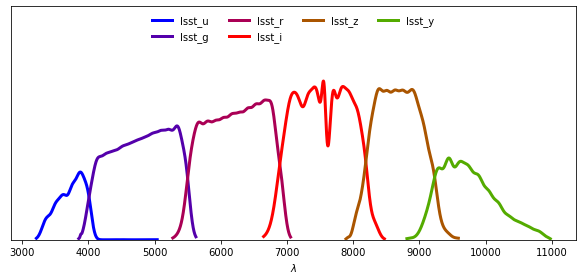

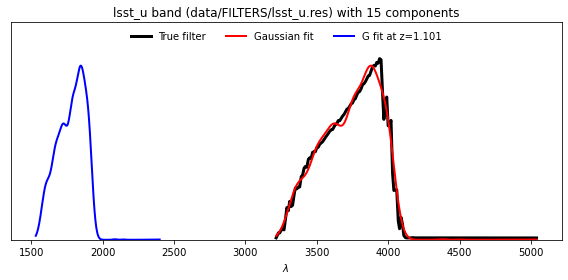

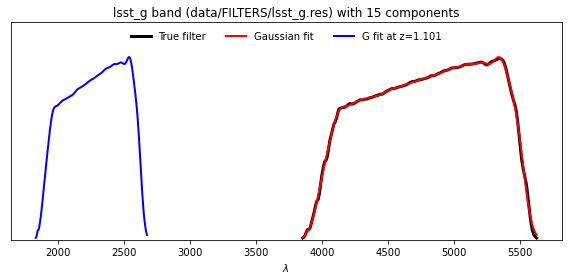

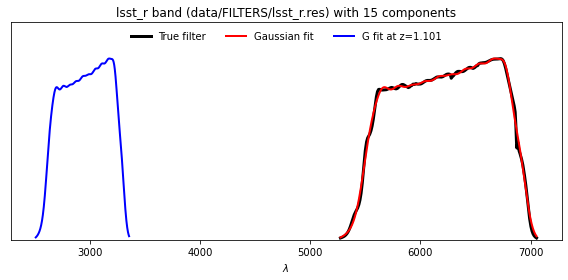

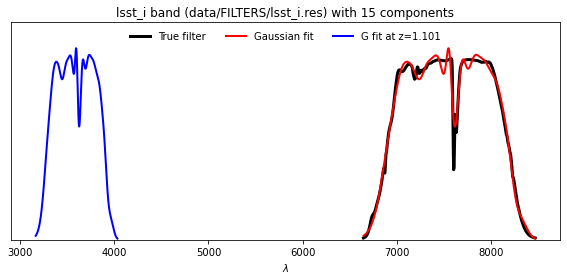

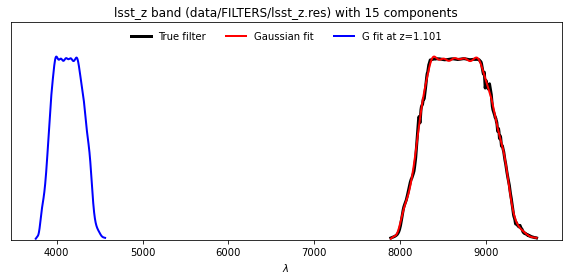

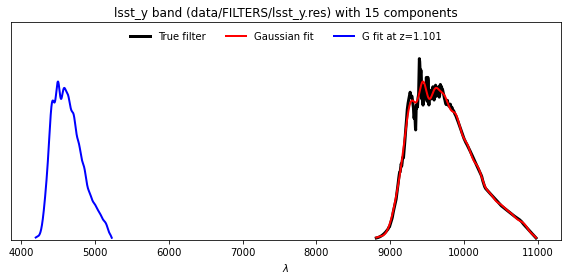

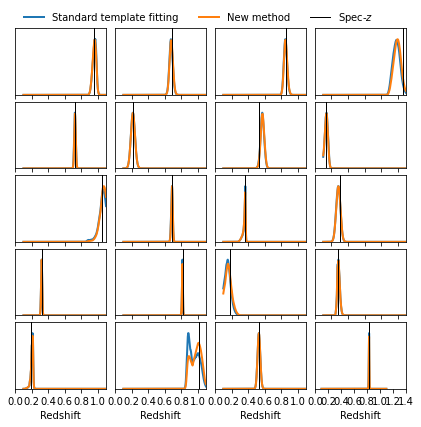

In [21]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(7, 6), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 1.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


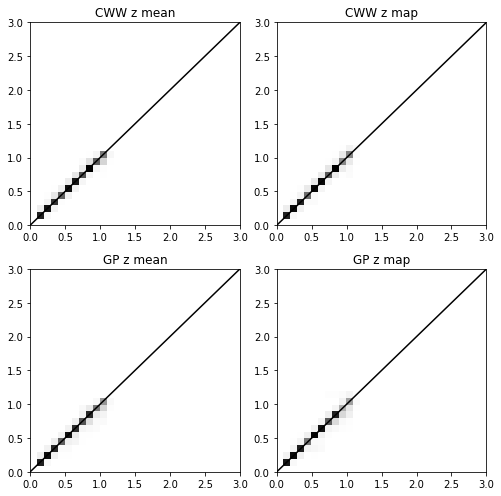

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
zmax = 3
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

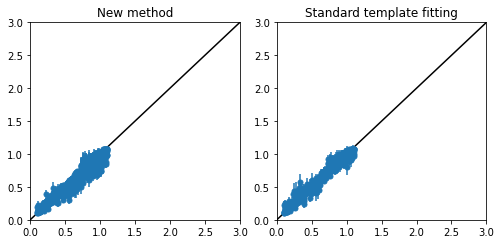

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

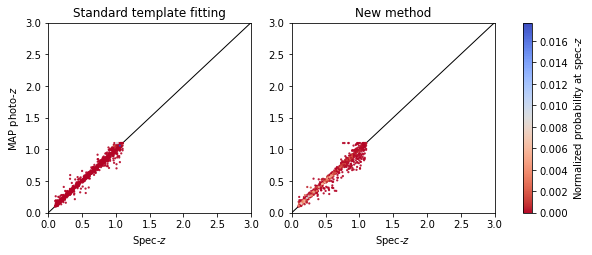

In [24]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.